# 1. Data Load

In [1]:
import numpy as np
import pandas as pd
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
# 한글 폰트가 깨지면 실행하세요! 
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
fontlist[:]

from matplotlib import font_manager, rc
#font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [3]:
path = "./Dataset/"

data = pd.read_csv(path+"kwproja_data_big.csv")
#data = pd.read_csv('../input/dolphin-kwproja-bigdata/kwproja_data_big.csv')

# original data -> data
data

,date,shop_code,shop_name,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price
0,201709,24432350113,친쿡부대찌개 오류동본점,뷔페,고기 뷔페,126.844998,37.496882,12881013.37,21514
1,201709,13141330215,드럼통집,뷔페,고기 뷔페,127.096574,37.505706,33931612.72,52264
2,201706,39421720107,하우돈,뷔페,고기 뷔페,126.906290,37.518280,21456513.16,42656
3,201706,4602500509,고고생고기,뷔페,고기 뷔페,127.109240,37.501153,6140707.30,34561
4,201709,39313780106,현대식당,뷔페,고기 뷔페,126.980601,37.518535,6091482.50,38423
...,...,...,...,...,...,...,...,...,...
2927734,201803,66340980106,최가네 남원추어탕,수산물,회/수산물 일반,126.963825,37.526863,13693767.90,21511
2927735,201803,7211800169,우미도라꾸,수산물,회/수산물 일반,127.070132,37.536551,17432801.29,74559
2927736,201804,7408500552,연안해물칼국수 행당점,수산물,회/수산물 일반,127.033712,37.559118,17023101.74,34212
2927737,201803,36412610212,동해수산,수산물,회/수산물 일반,127.127448,37.537151,31533908.77,52973


# EDA 

2,927,739 rows X 9 columns

- 매장 속성 정보
  - shop_code -> 식별자 feature, input feature로는 사용하지 않지만 분류를 위해서는 사용할 수 있을 것 같음  
  - shop_name -> input feature로는 사용하지 않음 (NLP deep learning 가능성 있음)
  - longtitude : 경도, latitude : 위도 -> 매장 위치 (회사 근처, 학교 근처 등 매출 영향성 있음) -> 군집화, labeling 필요
  - shop_type_big -> 15 category  -> 업종 (매출 영향성 있음)
  - shop_type_small -> 61 category

- 매출 정보
  - date -> 24 category, 201606~ 201805 까지의 data
  - monthly_gain / avearge_sale_price = 한달 총 판매수

- 매출 통계 정보-> X


##### monthly_gain과 average_sale_price 중 어느 것을 y값으로 둘 것인가? 
- 월매출 예측 문제로 가정하고 montly_gain 을 y값으로 예측하는 모델 만들기

##### shop_code는 input feature에 넣어야 하는가?
- 특별한 브랜드가 y값을 결정하는 과적합 요소가 될 수 있으므로
- X 에서 shop code, shop name 제외하는 것도 방법
- 어느 위치에 어떤 업종으로 어떤 객단가인 매장을 오픈하면 월매출이 어떻게 될까? 문제
 - X: shop type big, shop type small, longitude, latitude, avg_sale_price, 
 - y: montly_gain

In [4]:
data.columns

Index(['date', 'shop_code', 'shop_name', 'shop_type_big', 'shop_type_small',
       'longitude', 'latitude', 'monthly_gain', 'average_sale_price'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927739 entries, 0 to 2927738
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                int64  
 1   shop_code           int64  
 2   shop_name           object 
 3   shop_type_big       object 
 4   shop_type_small     object 
 5   longitude           float64
 6   latitude            float64
 7   monthly_gain        float64
 8   average_sale_price  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 201.0+ MB


# 3. Preprocessing
data -> processed_data
- 9 columns : **shop_code | date | shop_name | shop_type_big | shop_type_small | longitude | latitude | average_sale_price | monthly_gain**
- shop_code : 식별자 feature 이므로 drop 
- date : 아직은 쓸 수 없으므로 drop
- missing value 제거 : A/N
- shop_type_big(15), shop_type_small(61) 
    - ML : label encodding
    - DL : NLP
- longitude, latitude : 
    - ML : k-mean clustering -> geo column 
    - DL : NLP, reverse geo encoder(행정동, 법정동, 지번주소, 도로명주소) -> 지번주소 가져오세요(for web) 
    - 행정동admcode, 법정동legalcode -> area1, area2, area3, area4
    - 지번 주소addr -> area1, area2, area3, area4 (x), land -> namber1, number2
    - 도로명 주소roadaddr -> area1, area2, area3, area4(x), land -> number1, number2, name  
- average_sale_price 
    - log transformation 
- MinMaxSaclar 정규화 -> 정규화 column의 범위는?? 실험필요 요인 

In [6]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
# feature drop : date, shop_code
processed_data = data.drop(['date', 'shop_code'], axis=1).copy()

In [7]:
# There are no missing values 
# missing value drop - monthly_gain
null_index = processed_data[processed_data['monthly_gain']==0].index 
print("monthly gain null : ", len(null_index))
processed_data = processed_data.drop(null_index)

# missing value drop - average_sale_price
null_index = processed_data[processed_data['average_sale_price']==0].index 
print("average sale price null : ", len(null_index))
processed_data = processed_data.drop(null_index)

# missing value drop - shop_type_big
null_index = processed_data[processed_data['shop_type_big'].isnull()==True].index
print("shop type big null : ", len(null_index))
print("shop type big unique : ", processed_data['shop_type_big'].nunique())
processed_data = processed_data.drop(null_index)

# missing value drop - shop_type_small 
null_index = processed_data[processed_data['shop_type_small'].isnull()==True].index
print("shop type small null : ", len(null_index))
print("shop type small unique : ", processed_data['shop_type_small'].nunique() )

monthly gain null :  0
average sale price null :  0
shop type big null :  0
shop type big unique :  15
shop type small null :  0
shop type small unique :  61


In [8]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

# fit transform으로 한번에 처리 가능
le = LabelEncoder()
processed_data['shop_type_big_label'] = le.fit_transform(list(processed_data['shop_type_big']))   
print(le.classes_)

le = LabelEncoder()
processed_data['shop_type_small_label'] = le.fit_transform(list(processed_data['shop_type_small'])) 
print(le.classes_)

# NLP용 preprocessing 
# shop_name, shop_type_big, shop_type_small = concat_text 
processed_data['concat_text'] = processed_data['shop_name'] + " " + processed_data['shop_type_big'] + " " + processed_data['shop_type_small']

['다방/커피숍/카페' '별식/퓨전요리' '분식' '뷔페' '생활서비스' '소매' '수산물' '양식' '유흥주점' '음식-미분류'
 '일식' '제과제빵떡케익' '중식' '패스트푸드' '한식']
['고기 뷔페' '고기구이/육회 전문점' '곱창/양구이 전문점' '구내식당' '국수/수제비 전문점' '기타세계요리 전문점'
 '낙지/문어/오징어/쭈꾸미 전문점' '냉면 전문점' '덮밥/가정식' '도너츠/꽈배기/고로케/호떡 전문점'
 '도시락/컵밥/주먹밥/배달음식 전문점' '돈가스 전문점' '떡/한과 전문점' '마라/양꼬치/훠궈 전문점' '면 전문점'
 '미분류 유흥업소' '민속주점' '바닷가재/게요리 전문점' '반찬 판매' '백화점' '버거 전문점' '베트남음식 전문점'
 '보쌈/족발 전문점' '분식 전문점' '샌드위치/토스트/핫도그 전문점' '샤브샤브 전문점' '세탁소' '소주방/포장마차'
 '순대 전문점' '슈퍼/잡화/할인매장' '스테이크 전문점' '식료품' '아이스크림/빙수 판매' '오리/닭요리 전문점'
 '오리/닭요리/탕/백숙 전문점' '와인/칵테일/위스키 바' '음식-미분류' '이자까야/꼬치구이' '이태리 전문점'
 '인도음식 전문점' '일반 중식당' '장어 전문점' '전통찻집' '제과/제빵 전문점' '조개 전문점' '종합 뷔페'
 '죽요리 전문점' '참치 전문점' '초밥 전문점' '치킨/닭강정 전문점' '카레 전문점' '카페/디저트' '테이크아웃 음료 전문점'
 '편의점' '퓨전음식 전문점' '피자 전문점' '한식국물요리 전문점' '한정식/백반 전문점' '호프/맥주' '화로구이 전문점'
 '회/수산물 일반']


In [9]:
# BinaryEncoder for categorical variable 
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=["shop_type_big", "shop_type_small"])
df = encoder.fit_transform(processed_data[["shop_type_big", "shop_type_small"]])

processed_data = pd.concat([processed_data, df], axis=1)

C:\Users\Hyeongbin\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[[ 37.53989547 126.84569676]
 [ 37.50142324 127.03444735]
 [ 37.56580606 126.99380788]
 [ 37.49487017 126.89656781]
 [ 37.57093825 127.06697168]
 [ 37.51705226 127.12109922]
 [ 37.57408946 126.92450895]
 [ 37.49674245 126.951816  ]
 [ 37.63891585 127.04528207]]
[0 5 3 ... 4 5 3]


Text(0.5, 1.0, 'k-mean')

C:\Users\Hyeongbin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


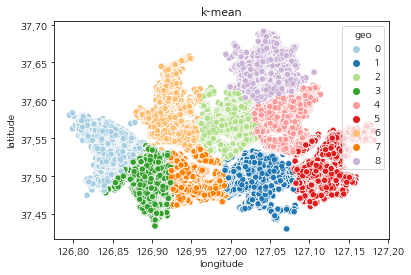

In [10]:
# Labeling - KMeans Clustering 
# longitude + latitude = geo 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9).fit(processed_data[['latitude', 'longitude']])
print(kmeans.cluster_centers_)
print(kmeans.labels_)

processed_data['geo'] = kmeans.labels_

# plotting geo
sns.scatterplot(x='longitude' , y='latitude', hue="geo", data=processed_data, palette="Paired")
plt.title('k-mean')

# NLP 처리를 위해서 featrue drop은 생략합니다! 
#processed_data = processed_data.drop(['longitude', 'latitude'], axis=1)

In [11]:
# average_sale_price -> skewed data 
# log transfromation 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer

scale_cols = ['average_sale_price']
processed_data[scale_cols] = processed_data[scale_cols].apply(lambda x : np.log1p(x))

processed_data

,shop_name,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price,shop_type_big_label,shop_type_small_label,concat_text,...,shop_type_big_3,shop_type_big_4,shop_type_small_0,shop_type_small_1,shop_type_small_2,shop_type_small_3,shop_type_small_4,shop_type_small_5,shop_type_small_6,geo
0,친쿡부대찌개 오류동본점,뷔페,고기 뷔페,126.844998,37.496882,12881013.37,9.976506,3,0,친쿡부대찌개 오류동본점 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,0
1,드럼통집,뷔페,고기 뷔페,127.096574,37.505706,33931612.72,10.864082,3,0,드럼통집 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,5
2,하우돈,뷔페,고기 뷔페,126.906290,37.518280,21456513.16,10.660947,3,0,하우돈 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,3
3,고고생고기,뷔페,고기 뷔페,127.109240,37.501153,6140707.30,10.450510,3,0,고고생고기 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,5
4,현대식당,뷔페,고기 뷔페,126.980601,37.518535,6091482.50,10.556438,3,0,현대식당 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927734,최가네 남원추어탕,수산물,회/수산물 일반,126.963825,37.526863,13693767.90,9.976366,6,60,최가네 남원추어탕 수산물 회/수산물 일반,...,0,1,0,1,1,1,1,0,1,7
2927735,우미도라꾸,수산물,회/수산물 일반,127.070132,37.536551,17432801.29,11.219359,6,60,우미도라꾸 수산물 회/수산물 일반,...,0,1,0,1,1,1,1,0,1,4
2927736,연안해물칼국수 행당점,수산물,회/수산물 일반,127.033712,37.559118,17023101.74,10.440361,6,60,연안해물칼국수 행당점 수산물 회/수산물 일반,...,0,1,0,1,1,1,1,0,1,4
2927737,동해수산,수산물,회/수산물 일반,127.127448,37.537151,31533908.77,10.877557,6,60,동해수산 수산물 회/수산물 일반,...,0,1,0,1,1,1,1,0,1,5


In [68]:
# removing outlier 
# upper fence, lower fence 외 값(outlier)를 제거합니다 
def get_pricelist(i, data) :
    df = data[['shop_type_big_label','monthly_gain']].groupby('shop_type_big_label')
    Q1 = df.get_group(i)['monthly_gain'].quantile(0.25)
    Q2 = df.get_group(i)['monthly_gain'].quantile(0.5)
    Q3 = df.get_group(i)['monthly_gain'].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    if lower_fence <= 0 : lower_fence = 0
        
    return lower_fence, Q1, Q2, Q3, upper_fence

def remove_outlier(data) :
    output_data = data.copy()
    for i in range(0,15) :
        lower_fence, Q1, Q2, Q3, upper_fence = get_pricelist(i, data)
        shoptype_index = data[data.shop_type_big_label == i].index
        shoptype_data = data.iloc[shoptype_index, :]
        outlier_index = shoptype_data[shoptype_data.monthly_gain > upper_fence].index
        print("removed index in shop_type_big" , i, ": ", len(outlier_index))
        output_data = output_data.drop(outlier_index)
    return output_data 

processed_data = remove_outlier(processed_data)
processed_data

removed index in shop_type_big 0 :  25133
removed index in shop_type_big 1 :  15726
removed index in shop_type_big 2 :  12003
removed index in shop_type_big 3 :  2393
removed index in shop_type_big 4 :  1
removed index in shop_type_big 5 :  26678
removed index in shop_type_big 6 :  8612
removed index in shop_type_big 7 :  1188
removed index in shop_type_big 8 :  19350
removed index in shop_type_big 9 :  50532
removed index in shop_type_big 10 :  6064
removed index in shop_type_big 11 :  5384
removed index in shop_type_big 12 :  8360
removed index in shop_type_big 13 :  11580
removed index in shop_type_big 14 :  40136


,shop_name,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price,shop_type_big_label,shop_type_small_label,concat_text,...,shop_type_big_3,shop_type_big_4,shop_type_small_0,shop_type_small_1,shop_type_small_2,shop_type_small_3,shop_type_small_4,shop_type_small_5,shop_type_small_6,geo
0,친쿡부대찌개 오류동본점,뷔페,고기 뷔페,126.84,37.50,12881013.37,9.98,3,0,친쿡부대찌개 오류동본점 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,5
1,드럼통집,뷔페,고기 뷔페,127.10,37.51,33931612.72,10.86,3,0,드럼통집 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,0
2,하우돈,뷔페,고기 뷔페,126.91,37.52,21456513.16,10.66,3,0,하우돈 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,7
3,고고생고기,뷔페,고기 뷔페,127.11,37.50,6140707.30,10.45,3,0,고고생고기 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,0
4,현대식당,뷔페,고기 뷔페,126.98,37.52,6091482.50,10.56,3,0,현대식당 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927734,최가네 남원추어탕,수산물,회/수산물 일반,126.96,37.53,13693767.90,9.98,6,60,최가네 남원추어탕 수산물 회/수산물 일반,...,0,1,0,1,1,1,1,0,1,3
2927735,우미도라꾸,수산물,회/수산물 일반,127.07,37.54,17432801.29,11.22,6,60,우미도라꾸 수산물 회/수산물 일반,...,0,1,0,1,1,1,1,0,1,2
2927736,연안해물칼국수 행당점,수산물,회/수산물 일반,127.03,37.56,17023101.74,10.44,6,60,연안해물칼국수 행당점 수산물 회/수산물 일반,...,0,1,0,1,1,1,1,0,1,2
2927737,동해수산,수산물,회/수산물 일반,127.13,37.54,31533908.77,10.88,6,60,동해수산 수산물 회/수산물 일반,...,0,1,0,1,1,1,1,0,1,0


# 4. 타겟변수 확인
why(or when) to use log transform in ML? 
- target variable이 non-negative values 일때만 
- outlier 값들도 사용해야 하는 경우, outliers that can't be filtered out as they are important to the model.
- 현재 주어진 data도 좌측으로 치우쳐진 (right skewed) 형태, 굉장히 극소수의 업종들만이 굉장히 큰 매출을 만들어낼 수 있는 것으로 보임 
- 어떤 column, feature가 가장 monthly_gain과 상관관계가 높을까요? 
- kaggle house price prediction 대회에서도 RMSE가 아닌 RMSLE를 사용함 -> log를 씌운 형태인데 target variable인 집값의 범위가 넒기 때문

- Skewness: The longer the right tail, the more positive the tail
- Kurtosis (kurtosis / kurtosis): If the kurtosis value (K) is close to 3, the scatter is close to the normal distribution. (K <3), the distributions can be judged to be flattened more smoothly than the normal distribution, and if the kurtosis is a positive number larger than 3 (K> 3), the distribution can be considered to be a more pointed distribution than the normal distribution

In [12]:
# pandas option 설정 하는 코드
# monthly_gain의 경우 부동소수점으로 나타나서 보기 어려울땐 윗 줄의 주석을 제거하고 아래에 주석을 추가하고
# 다시 원래대로 돌리고 싶다면 아래에 주석제거, 위 코드에 주석추가
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('display.float_format')

In [13]:
processed_data

,shop_name,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price,shop_type_big_label,shop_type_small_label,concat_text,...,shop_type_big_3,shop_type_big_4,shop_type_small_0,shop_type_small_1,shop_type_small_2,shop_type_small_3,shop_type_small_4,shop_type_small_5,shop_type_small_6,geo
0,친쿡부대찌개 오류동본점,뷔페,고기 뷔페,126.84,37.50,12881013.37,9.98,3,0,친쿡부대찌개 오류동본점 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,0
1,드럼통집,뷔페,고기 뷔페,127.10,37.51,33931612.72,10.86,3,0,드럼통집 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,5
2,하우돈,뷔페,고기 뷔페,126.91,37.52,21456513.16,10.66,3,0,하우돈 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,3
3,고고생고기,뷔페,고기 뷔페,127.11,37.50,6140707.30,10.45,3,0,고고생고기 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,5
4,현대식당,뷔페,고기 뷔페,126.98,37.52,6091482.50,10.56,3,0,현대식당 뷔페 고기 뷔페,...,0,1,0,0,0,0,0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927734,최가네 남원추어탕,수산물,회/수산물 일반,126.96,37.53,13693767.90,9.98,6,60,최가네 남원추어탕 수산물 회/수산물 일반,...,0,1,0,1,1,1,1,0,1,7
2927735,우미도라꾸,수산물,회/수산물 일반,127.07,37.54,17432801.29,11.22,6,60,우미도라꾸 수산물 회/수산물 일반,...,0,1,0,1,1,1,1,0,1,4
2927736,연안해물칼국수 행당점,수산물,회/수산물 일반,127.03,37.56,17023101.74,10.44,6,60,연안해물칼국수 행당점 수산물 회/수산물 일반,...,0,1,0,1,1,1,1,0,1,4
2927737,동해수산,수산물,회/수산물 일반,127.13,37.54,31533908.77,10.88,6,60,동해수산 수산물 회/수산물 일반,...,0,1,0,1,1,1,1,0,1,5


In [14]:
print("Skewness: %f" % data['monthly_gain'].skew())
print("Kurtosis: %f" % data['monthly_gain'].kurt())

Skewness: 165.584485
Kurtosis: 37638.372288


C:\Users\Hyeongbin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

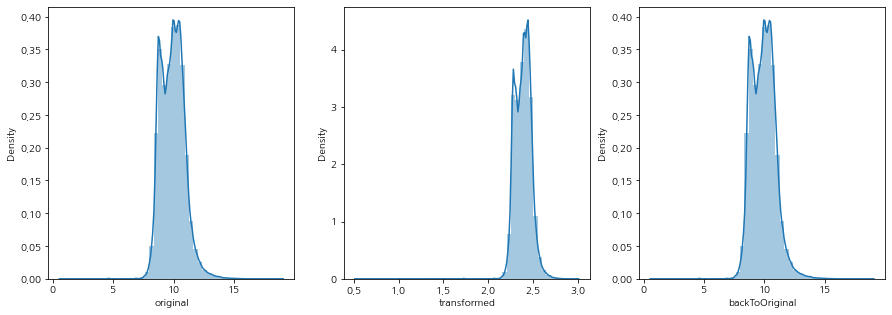

In [15]:
plots=pd.DataFrame()
plots['original']=processed_data['average_sale_price']
plots['transformed']=np.log1p(processed_data['average_sale_price'])
plots['backToOriginal']=np.expm1(np.log1p(processed_data['average_sale_price']))

fig, ax = plt.subplots(1,3,figsize=(15,5))
sns.distplot(plots['original'], ax=ax[0]);
sns.distplot(plots['transformed'], ax=ax[1]);
sns.distplot(plots['backToOriginal'], ax=ax[2]);

C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


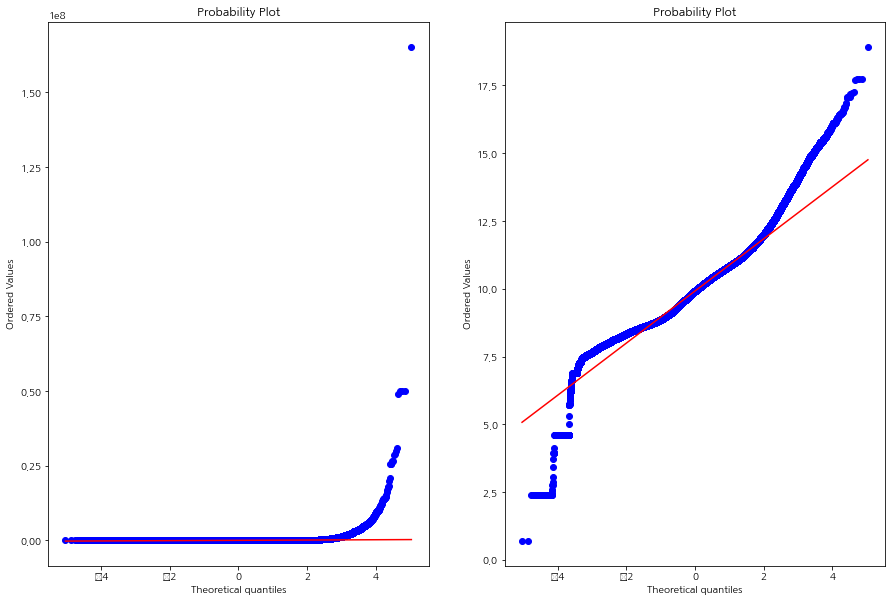

In [114]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(processed_data['average_sale_price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(processed_data['average_sale_price']), plot=plt)

# 5. Data Split 
전처리 완료, 필요한 column을 input으로 넣고 train / valid / test data split 

In [16]:
# 전처리된 data와 따로 관리 -> processed_data, model input data = input_data 
input_data = processed_data.copy()

#X_column_ml = ['average_sale_price', 'shop_type_big_label', 'shop_type_small_label', 'geo']
X_column_ml = ['average_sale_price', 'shop_type_big_0',
       'shop_type_big_1', 'shop_type_big_2', 'shop_type_big_3',
       'shop_type_big_4', 'shop_type_small_0', 'shop_type_small_1',
       'shop_type_small_2', 'shop_type_small_3', 'shop_type_small_4',
       'shop_type_small_5', 'shop_type_small_6', 'geo']
y_column_ml = ['monthly_gain']

input_data_X = input_data[X_column_ml].copy()
input_data_y = input_data[y_column_ml].copy()

In [17]:
from sklearn.model_selection import train_test_split, cross_validate, KFold, TimeSeriesSplit,GridSearchCV

train_X, test_X, train_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2,
    random_state = 17,
    shuffle=True)  

# 6. Modeling
- XGB
    - 타겟변수 정규화 실행 
- LGBM
    - loss parameter : tweedie 
- K-Fold Cross Validation (k=5)

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
from keras.callbacks import EarlyStopping, ModelCheckpoint

from lightgbm import LGBMRegressor
from lightgbm import plot_importance 
from xgboost import XGBRegressor
from xgboost import plot_importance

model_xgb = XGBRegressor()
model_lgbm = LGBMRegressor()

In [19]:
kfold = KFold(n_splits=5, shuffle=True, random_state = 7)
cv_accuracy = []
n_iter =0

for train_index, valid_index in kfold.split(train_X):  # 데이터를 kfold = 5 로 분할
    x_train, x_valid = train_X.iloc[list(train_index)], train_X.iloc[list(valid_index)]
    y_train, y_valid = train_y.iloc[list(train_index)], train_y.iloc[list(valid_index)]
    #y_train, y_valid = np.log1p(y_train), np.log1p(y_valid)

    model_xgb.fit(x_train, y_train)
    pred = model_xgb.predict(x_valid)
    n_iter += 1
    
    mse = np.round(mean_squared_error(y_valid, pred), 4) # 소수점 4자리 반올림
    rmse = np.sqrt(mse)
    train_size = x_train.shape[0]
    test_size = x_valid.shape[0]
    
    print('\n#{0} 교차 검증 rmse : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, rmse, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,valid_index))
    cv_accuracy.append(rmse)
    
print('\n## 평균 검증 rmse:', np.mean(cv_accuracy))


#1 교차 검증 rmse : 518803301.8555069,  학습 데이터 크기 : 1873752,  검증 데이터 크기 : 468439
#1 검증 세트 인덱스 : [      1       3       8 ... 2342187 2342189 2342190]

#2 교차 검증 rmse : 346682780.00603074,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#2 검증 세트 인덱스 : [      4       6      10 ... 2342167 2342169 2342171]

#3 교차 검증 rmse : 422669441.4921849,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#3 검증 세트 인덱스 : [     20      21      24 ... 2342172 2342184 2342188]

#4 교차 검증 rmse : 525518621.81876236,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#4 검증 세트 인덱스 : [      0       5       9 ... 2342166 2342170 2342174]

#5 교차 검증 rmse : 360720714.25946504,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#5 검증 세트 인덱스 : [      2       7      13 ... 2342178 2342180 2342185]

## 평균 검증 rmse: 434878971.88639003


In [20]:
kfold = KFold(n_splits=5, shuffle=True, random_state = 7)
cv_accuracy = []
n_iter =0

for train_index, valid_index in kfold.split(train_X):  # 데이터를 kfold = 5 로 분할
    x_train, x_valid = train_X.iloc[list(train_index)], train_X.iloc[list(valid_index)]
    y_train, y_valid = train_y.iloc[list(train_index)], train_y.iloc[list(valid_index)]
    #y_train, y_valid = np.log1p(y_train), np.log1p(y_valid)
    
    model_lgbm.fit(x_train, y_train)
    pred = model_lgbm.predict(x_valid)
    n_iter += 1
    
    mse = np.round(mean_squared_error(y_valid, pred), 4) # 소수점 4자리 반올림
    rmse = np.sqrt(mse)
    train_size = x_train.shape[0]
    test_size = x_valid.shape[0]
    
    print('\n#{0} 교차 검증 rmse : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, rmse, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,valid_index))
    cv_accuracy.append(rmse)
    
print('\n## 평균 검증 rmse:', np.mean(cv_accuracy))


#1 교차 검증 rmse : 455120629.26443255,  학습 데이터 크기 : 1873752,  검증 데이터 크기 : 468439
#1 검증 세트 인덱스 : [      1       3       8 ... 2342187 2342189 2342190]

#2 교차 검증 rmse : 281878097.6323604,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#2 검증 세트 인덱스 : [      4       6      10 ... 2342167 2342169 2342171]

#3 교차 검증 rmse : 343443680.01747966,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#3 검증 세트 인덱스 : [     20      21      24 ... 2342172 2342184 2342188]

#4 교차 검증 rmse : 376068898.42208475,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#4 검증 세트 인덱스 : [      0       5       9 ... 2342166 2342170 2342174]

#5 교차 검증 rmse : 317031525.13054395,  학습 데이터 크기 : 1873753,  검증 데이터 크기 : 468438
#5 검증 세트 인덱스 : [      2       7      13 ... 2342178 2342180 2342185]

## 평균 검증 rmse: 354708566.0933803


In [21]:
pred_xgb = model_xgb.predict(test_X)
pred_lgbm = model_lgbm.predict(test_X)

In [ ]:
#pred_xgb_prob = model_xgb.predict_proba(test_X_ml)
#pred_xgb = np.argmax(pred_xgb_prob, axis=1)

#pred_lgbm_prob = model_lgbm.predict_proba(test_X_ml)
#pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

#pred_xgb

# 7. Evaluation
- mse : Mean Absolute Error, 평균 절대 오차, 측정값의 오차 크기, 측정값과 실제값과의 차이, 절대 오차의 평균
- rmse : Mean Square Error, 평균 제곱 오차, 오차의 제곱에 대한 평균을 취한 값 
    - 측정하고자 하는 값을 정확하게 측정하지 못함으로써 발생 
- R2 
    - 독립변수가 많을 수록 결정계수 r2 값은 커지므로, 독립변수가 2개 이상일 경우 조정된 결정계수 adj_r2를 사용
    - 기존의 결정계수 r2에 n(데이터 개수) 와 k(변수 개수)가 추가 됨 
    - r2 score는 regression model의 훌륭한 평가 지표이지만, 예측 모델과 실제 모델의 분산이 얼마나 비슷한지에 기반하기에 
    - 예측값과 실제값이 많이 달라도 분산만 비슷하면 높은 점수를 얻을 수 있다는 맹점이 있다 
- Mape : precision 과 recall의 조화평균

In [22]:
def plot_history(history):
    #hist = pd.DataFrame(history.history)
    #history['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))
    
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.legend()
    plt.show()
    
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result

def show_mse_rmse(test_y, pred) :
    mse = mean_squared_error(test_y, pred)
    print("mse : %f" % mse)
    
    rmse = np.sqrt(mse)
    print("rmse: %f \n" %rmse)

def show_r2_score(test_y, pred, test_X) : 
    r2 = r2_score(pred, test_y)
    print("r2 : %f " % r2)
    adj_r2 = 1 - (1-r2)*(test_X.shape[0]-1)/(test_X.shape[0]-test_X.shape[1]-1)
    print("adj_r2_score : %f \n" % adj_r2)
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

In [23]:
show_pred(test_y, pred_xgb)

,true_y,prediction
0,2301001.43,16608388.00
1,16784617.72,16271660.00
2,33041732.64,32098522.00
3,57783858.06,35942260.00
4,24490402.91,14893336.00
...,...,...
585543,24853305.22,13175693.00
585544,51874253.63,43986612.00
585545,60344041.62,21678302.00
585546,3614571.98,-6798780.00


In [24]:
show_pred(test_y, pred_lgbm)

,true_y,prediction
0,2301001.43,11934824.03
1,16784617.72,22473134.54
2,33041732.64,26193444.46
3,57783858.06,33135576.52
4,24490402.91,15966456.36
...,...,...
585543,24853305.22,14093563.77
585544,51874253.63,42538642.85
585545,60344041.62,19226280.01
585546,3614571.98,78250478.43


In [25]:
show_mse_rmse(test_y, pred_xgb)
show_r2_score(test_y, pred_xgb, test_X)

mse : 171145093734679104.000000
rmse: 413696862.128152 

r2 : -0.590329 
adj_r2_score : -0.590367 



In [26]:
show_mse_rmse(test_y, pred_lgbm)
show_r2_score(test_y, pred_lgbm, test_X)

mse : 125075186697217808.000000
rmse: 353659704.655786 

r2 : -0.092626 
adj_r2_score : -0.092652 



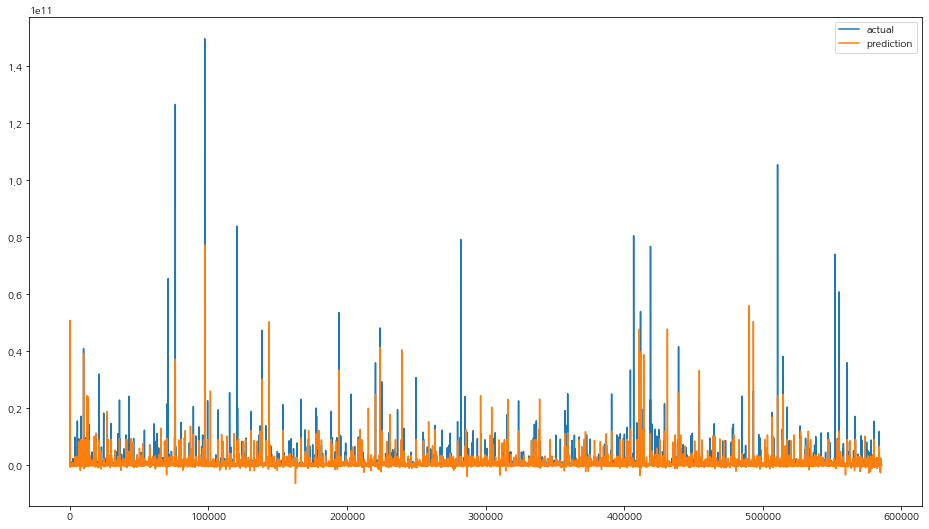

In [29]:
true_y = test_y.to_numpy()
graph(pred_xgb, true_y)

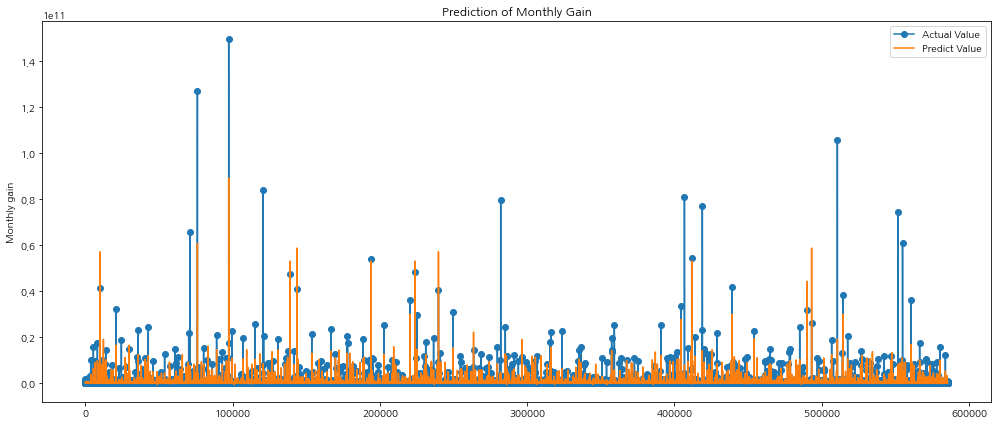

In [30]:
plt.figure(figsize=(17,7))
plt.plot(range(0, len(test_y)), test_y,'o-', label='Actual Value')
plt.plot(range(0, len(pred_xgb)), pred_lgbm, '-', label='Predict Value')
plt.title('Prediction of Monthly Gain')
plt.ylabel('Monthly gain')
plt.legend()

<AxesSubplot:>

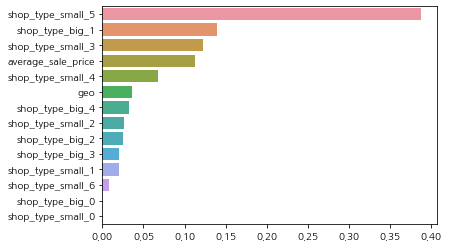

In [31]:
feature_series = pd.Series(data=model_xgb.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

<AxesSubplot:>

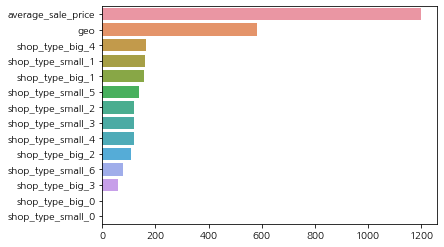

In [32]:
feature_series = pd.Series(data=model_lgbm.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)